### **Setup**

In [59]:
import pandas as pd
import numpy as np
import shap 
from xgboost import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle 
import glob

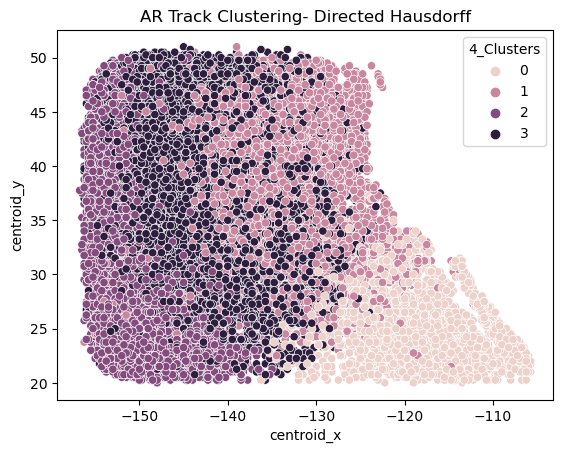

## **Global XGBoost**

### **Data Preprocessing**

In [5]:
# Read in the AR-Teleconnection Pattern Climatology
ar_tcp = pd.read_csv('PacificAR_Strength-Attributes.csv')

# Predicting the strength of each AR
y = ar_tcp['strength']

# Using these attributes
x = ar_tcp[[ 'centroid_y', 'centroid_x', 'PMM', 'QBO', 'MEI', 'Curvature', 'Displacement', 'origin_lat',
       'Amplitude', 'pna_index_cdas', 'nao_index_cdas', 'month']] # Note that MJO Phase, origin_lon, and SSD_Theta (Axis Curvature) have been removed following the results of feature selection

# Seperate into Test-Train splits
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42, shuffle=True)


### **Model Building & Training**

In [17]:
# The optimal hyperparameters established during feature selection/hyperparameter optimization
xgb_params =  {'n_estimators': 432, 
               'learning_rate': 0.387514395454483,
                 'num_leaves': 20 }

# Initiate the XGBoosted regression using the optimal hyperparameters 
xgb_reg = XGBRegressor(**xgb_params)#,objective='reg:squarederror')

# Train the XGBmodel
xgb_reg.fit(X_train,y_train)

[14:01:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.387514395454483,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=432, n_jobs=None, num_leaves=20,
             num_parallel_tree=None, predictor=None, ...)

### **Shapley Importance Visualizations**

**Calculate the Shapley Importance Values**

In [27]:
# Build the explainer object
explainer = shap.Explainer(xgb_reg.predict,X_test)
# Calculate Shapley values on the testing dataset
shap_values = explainer(X_test)

Permutation explainer: 4654it [06:50, 11.11it/s]                          


**Plot Visualizations**

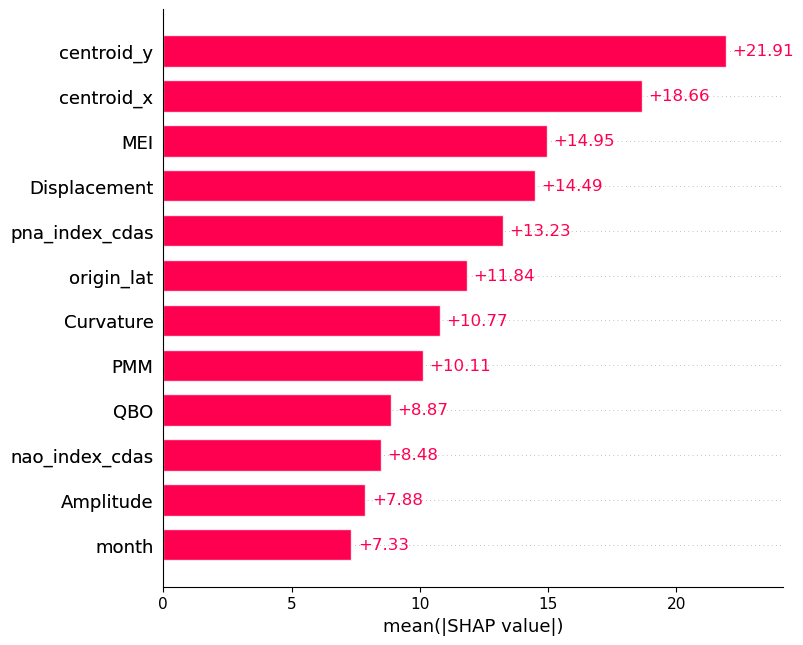

In [31]:
shap.plots.bar(shap_values,max_display=13)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


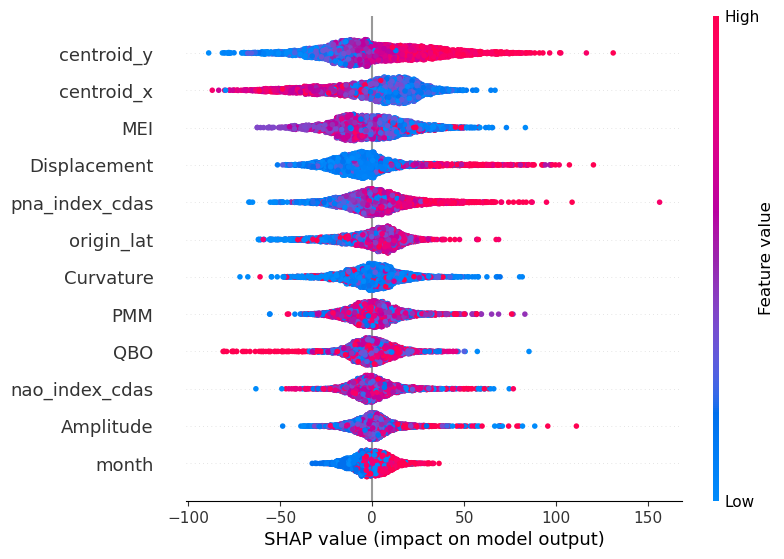

In [30]:
shap.plots.beeswarm(shap_values,max_display=13)

## **Stratified XGboost**

### **Functions**

In [60]:
def calculate_shapley_values(xgb_model_fname,xgm_model_featurelist_fname,ar_tcp_df):

    # Initiate the Cluster's XGBmodel
    xgb_reg = XGBRegressor()
    xgb_reg.load_model(xgb_model_fname)

    # Grab the retained features
    with open(xgm_model_featurelist_fname, 'rb') as file:
        loaded_column_names = pickle.load(file)
    
    # Grab the cluster's retained features from the AR-teleconnection pattern dataframe
    x = ar_tcp_df[loaded_column_names] 
    y = ar_tcp['strength'] 

    # Seperate into Test-Train splits
    X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42, shuffle=True)

    # Train the XGBmodel
    xgb_reg.fit(X_train,y_train)

    # Calculate the Shapley Importance on the testing set
    explainer = shap.Explainer(xgb_reg.predict,X_test)

    shap_values = explainer(X_test)

    return shap_values


In [62]:
def cluster_shapley_values(ar_tcp_df,xgb_model_list,xgb_model_retained_features):

    # Initiate the a list for the shap values within each cluster
    cluster_shap_values = []

    # Iterate through each cluster
    for i in range(len(xgb_model_list)):

        # Grab each cluster's model parameters and selected features
        model_fname = xgb_model_list[i]
        features_fname = xgb_model_retained_features[i]

        # Calculate the cluster's shap values
        shap_values = calculate_shapley_values(model_fname,features_fname,ar_tcp_df)

        # Add it to the output list
        cluster_shap_values.append(shap_values)

    return cluster_shap_values


### **Cluster Shapley Importance**

**Data Preprocessing**

In [67]:
# Read in the Labelled AR-Teleconnection Pattern Climatology
ar_tcp = pd.read_csv('WestCoastAR-TCP_clustered.csv')
ar_tcp['month'] = pd.to_datetime(ar_tcp['datetime']).dt.month # I will get to this, eventually...

# Get lists of filenames for each cluster's model and retained attributes/features
xgb_model_list = glob.glob('*XGBmodel.txt')
xgb_model_retained_features = glob.glob('*RetainedFeatures.pkl')

**Calculate Shapley Importance for each cluster**

In [68]:
all_shapley_values = cluster_shapley_values(ar_tcp,xgb_model_list,xgb_model_retained_features)

[14:54:28] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.



Exact explainer: 4654it [02:28, 29.10it/s]                          


[14:56:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.



Permutation explainer: 4654it [05:55, 12.73it/s]                          


[15:02:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.



Permutation explainer: 4654it [05:44, 13.12it/s]                          


[15:08:43] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_leaves" } are not used.



Permutation explainer: 4654it [05:54, 12.76it/s]                          


**Save the Shapley values for each cluster**

In [69]:
with open('Stratified_XGB_ShapleyValues.pkl', 'wb') as file:
    pickle.dump(all_shapley_values, file)

#### Cluster 0

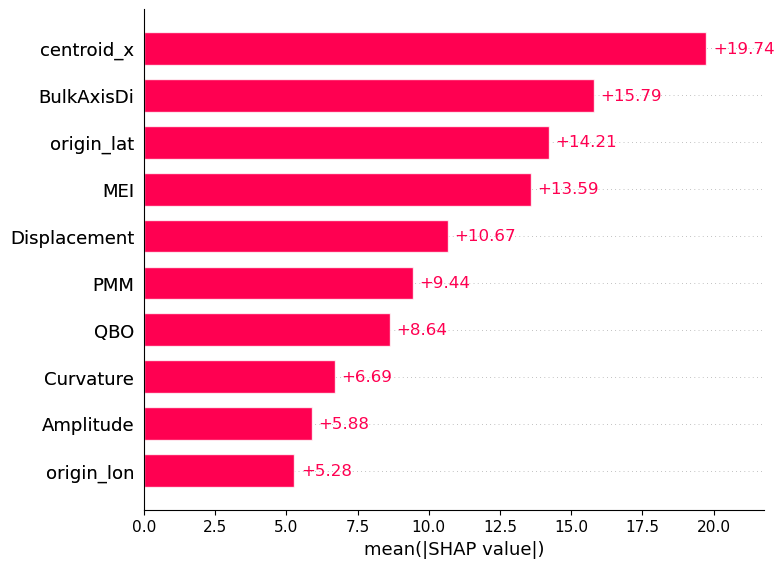

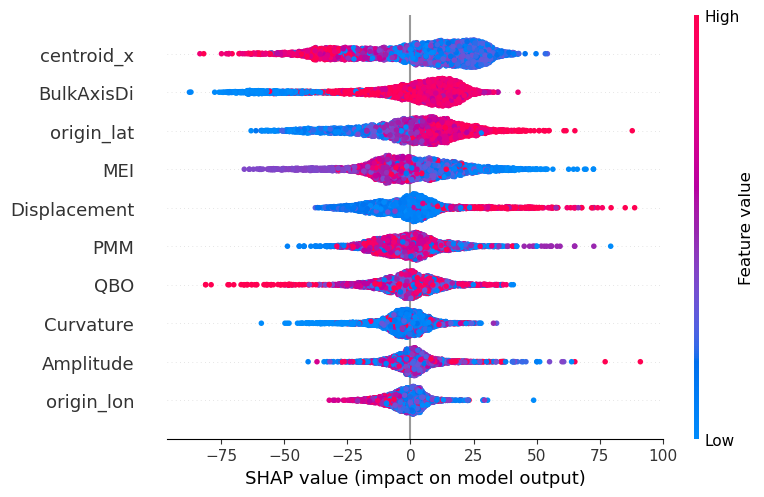

In [73]:
shap.plots.bar(all_shapley_values[0])
shap.plots.beeswarm(all_shapley_values[0])

#### Cluster 1

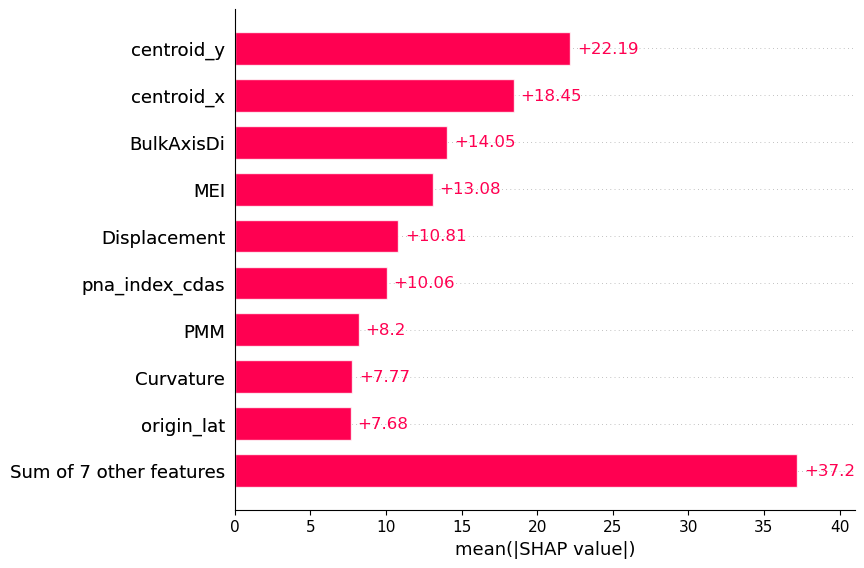

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


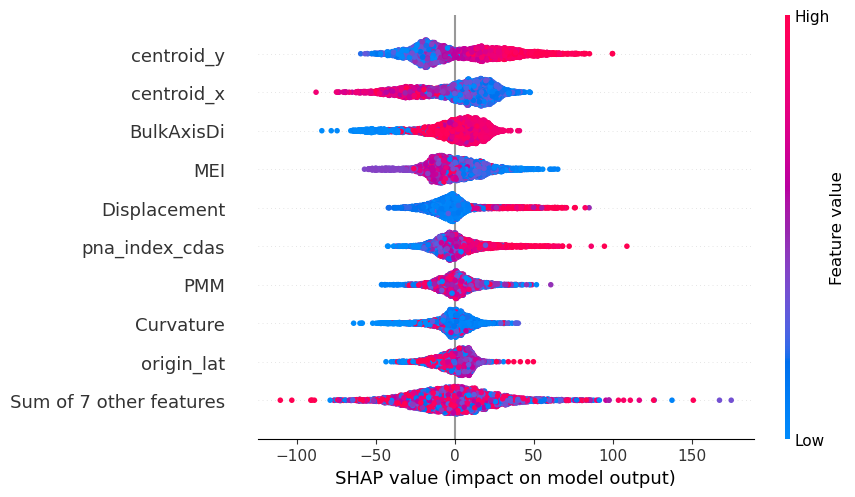

In [72]:
shap.plots.bar(all_shapley_values[1])
shap.plots.beeswarm(all_shapley_values[1])

#### Cluster 2

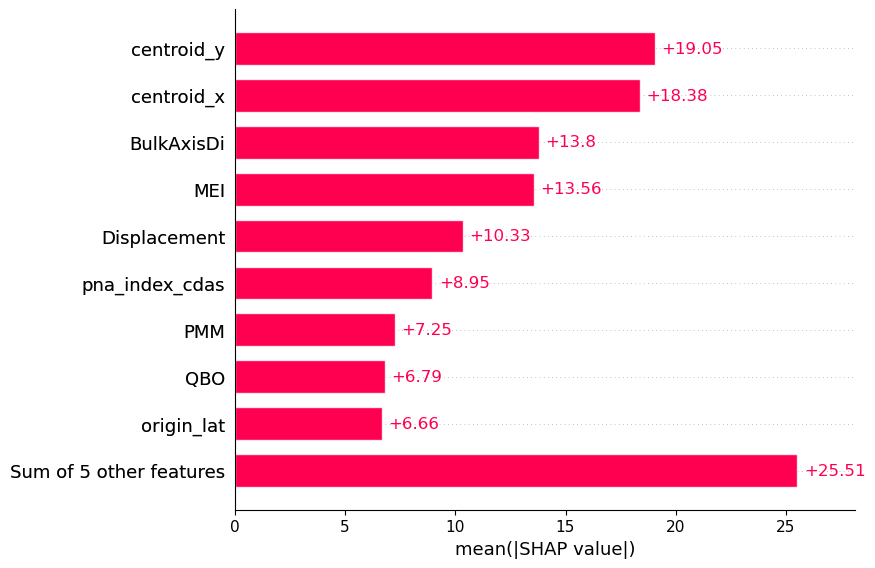

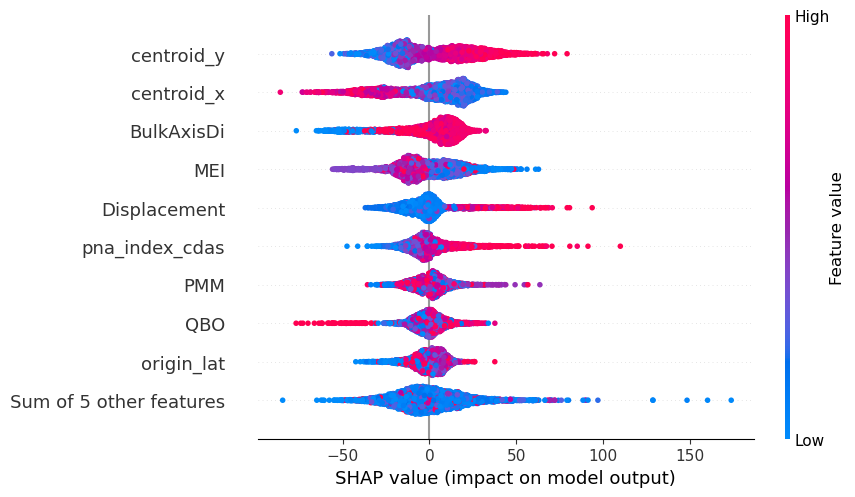

In [74]:
shap.plots.bar(all_shapley_values[2])
shap.plots.beeswarm(all_shapley_values[2])

#### Cluster 3

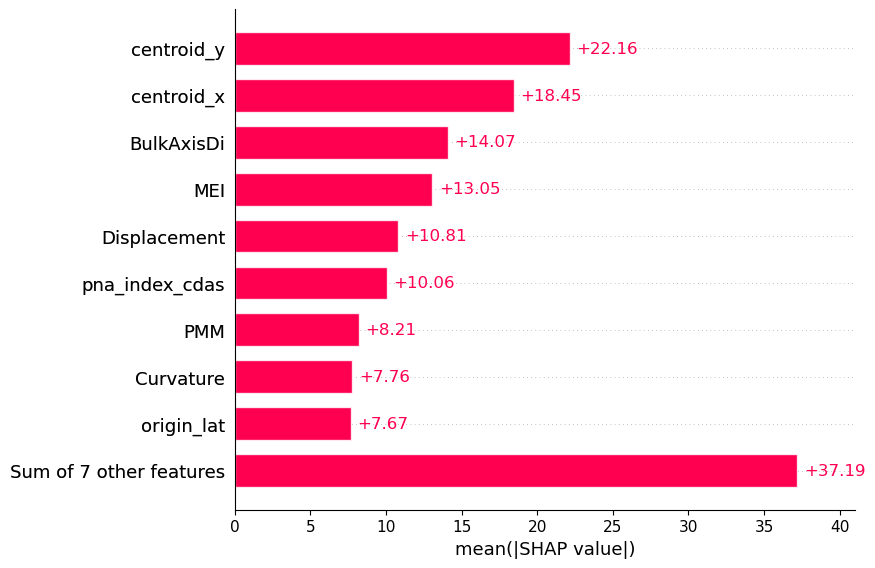

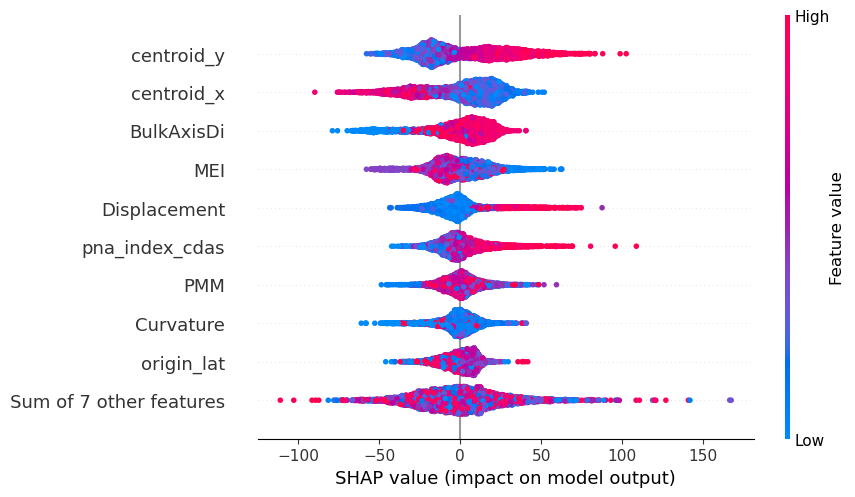

In [75]:
shap.plots.bar(all_shapley_values[3])
shap.plots.beeswarm(all_shapley_values[3])